### Machine Learning Operations - Assignment 2
Submitted by Arushi Makraria

In [2]:
import pandas as pd
import numpy as np
import mlflow
import hopsworks
import json
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from codecarbon import EmissionsTracker
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings 

warnings.filterwarnings('ignore')

In [3]:
athletes = pd.read_csv(r"/home/arushi/arushi/MLOPS/Assignment_2/athletes.csv")

Analyzing the data

In [4]:
athletes.shape

(423006, 27)

In [5]:
athletes.head(2)

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|


In [6]:
athletes.isna().sum()

athlete_id         3
name           91896
region        171744
team          267846
affiliate     181090
gender         91896
age            91896
height        263137
weight        193116
fran          367580
helen         392727
grace         382261
filthy50      403647
fgonebad      393268
run400        400760
run5k         386909
candj         318571
snatch        325726
deadlift      307683
backsq        312489
pullups       372398
eat           329074
train         317175
background    324061
experience    318070
schedule      325131
howlong       313800
dtype: int64

In [7]:
athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423006 entries, 0 to 423005
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   athlete_id  423003 non-null  float64
 1   name        331110 non-null  object 
 2   region      251262 non-null  object 
 3   team        155160 non-null  object 
 4   affiliate   241916 non-null  object 
 5   gender      331110 non-null  object 
 6   age         331110 non-null  float64
 7   height      159869 non-null  float64
 8   weight      229890 non-null  float64
 9   fran        55426 non-null   float64
 10  helen       30279 non-null   float64
 11  grace       40745 non-null   float64
 12  filthy50    19359 non-null   float64
 13  fgonebad    29738 non-null   float64
 14  run400      22246 non-null   float64
 15  run5k       36097 non-null   float64
 16  candj       104435 non-null  float64
 17  snatch      97280 non-null   float64
 18  deadlift    115323 non-null  float64
 19  ba

### Handling missing values and dropping NA's in columns related to target variable

In [8]:
athletes = athletes.dropna(subset = ['candj', 'snatch', 'deadlift', 'backsq', 'region'])

In [9]:
athletes = athletes.drop(columns = ["name", "team", "fran", "helen", "grace", "filthy50", "run400", "run5k", "fgonebad", "affiliate", "train"])

Removing outliers

In [10]:
athletes = athletes[athletes['weight'] < 400]
athletes = athletes[athletes['weight']>75]
athletes = athletes[athletes['gender'] != '--']
athletes = athletes[athletes['age'] >= 18]
athletes = athletes[(athletes['height'] < 96) & (athletes['height'] > 48)]
athletes = athletes[athletes['pullups']<80]
athletes = athletes[athletes['pullups']>0]

athletes = athletes[(athletes['deadlift'] > 0) & (athletes['deadlift'] <= 1105)|((athletes['gender'] == 'Female') \
                    & (athletes['deadlift'] <= 636))]
athletes = athletes[(athletes['candj'] > 0) & (athletes['candj'] <= 395)]
athletes = athletes[(athletes['snatch'] > 0) & (athletes['snatch'] <= 496)]
athletes = athletes[(athletes['backsq'] > 0) & (athletes['backsq'] <= 1069)]

In [11]:
#Binary feature for is male or not
def gender(x):
    if x == 'Male':
        return 1
    else:
        return 0

athletes['is_male'] = athletes['gender'].apply(gender)
athletes = athletes.drop('gender', axis = 1)

Categorical feature creation

In [12]:
def howlong(x):
    if isinstance(x, str):  
        if '4+ years|' in x:
            return 'Expert'
        elif '2-4 years|' in x:
            return 'Proficient'
        elif x == 'Decline to answer|':
            return np.nan
        else:
            return 'Amateur'
    else:
        return np.nan

athletes['experience_level'] = athletes['howlong'].apply(howlong)

In [13]:
def categorize_diet(x):
    # Check if the value is not a string (e.g., NaN)
    if not isinstance(x, str):
        return np.nan
    elif x == 'decline answer' or x == "":
        return np.nan
    elif 'eat strict paleo' in x:
        return 'Strict Diet'
    elif 'eat whatever convenient' in x:
        return 'No Diet'
    elif 'weigh measure food' in x or 'eat quality food measure amount' in x:
        return 'Normal Diet'
    else:
        return 'Normal Diet'

# Apply the updated function
athletes['diet'] = athletes['eat'].apply(categorize_diet)


In [14]:
def categorize_background(x):
    if isinstance(x, str):
        if x == 'decline answer' or x == "":
            return np.nan
        elif 'played professional sport' in x:
            return 'Professional Sports'
        elif 'played college sport' in x or 'played youth high school level sport' in x:
            return 'College or High School Sports'
        elif 'regularly play recreational sport' in x:
            return 'Recreational Sports'
        elif 'athletic background besides crossfit' in x:
            return 'CrossFit and Sports'
        else:
            return 'Recreational Sports'
    else:
        return np.nan

# Apply the categorization function to the 'background' column
athletes['athletic_background'] = athletes['background'].apply(categorize_background)

In [15]:
def experience(x):
    if not isinstance(x, str):
        return np.nan
    if x == 'decline answer' or  x == "":
        return np.nan
    elif any(phrase in x for phrase in ['train other', 'specialty course', 'level 1', 'certificate']):
        return 'Advanced (Trainer/Courses)'
    elif 'began' in x and 'coach' in x and 'affiliate' in x:
        return 'Beginner with coach'
    else:
        return 'Beginner without coach'
    
athletes['experience'] = athletes['experience'].apply(experience)

In [16]:


def categorize_schedule(x):
    if not isinstance(x, str):
        return np.nan
    if x == 'decline answer' or  x == "":
        return np.nan
    elif '1 workout' in x or 'only do 1' in x or '1x' in x:
        return 'Single workout per day'
    elif 'multiple workout' in x or '3+' in x or '2x' in x:
        return 'Multiple workouts per day'
    else:
        return 'Flexible'

athletes['workout_schedule'] = athletes['schedule'].apply(categorize_schedule)



Filling important NAs with Not provided

In [17]:
athletes['diet'] = athletes['diet'].fillna('Not Provided')
athletes['experience'] = athletes['experience'].fillna('Not Provided')
athletes['athletic_background'] = athletes['athletic_background'].fillna('Not Provided')
athletes['workout_schedule'] = athletes['workout_schedule'].fillna('Not Provided')
athletes['experience_level'] = athletes['experience_level'].fillna('Not Provided')

Creating a feature called BMI

In [18]:
athletes['BMI'] = (athletes['weight'] * 703) / (athletes['height'] ** 2)

Creating total lift

In [19]:
athletes['total_lift'] = athletes['candj'] + athletes['snatch'] + athletes['deadlift'] + athletes['backsq']

Cleaning the data

In [20]:
athletes = athletes.drop(columns = ['candj', 'snatch', 'deadlift', 'backsq'])

In [21]:
athletes = athletes.drop(columns = ['eat', 'background', 'schedule'])

In [22]:
athletes = athletes.drop( columns='howlong')

In [23]:
athletes.isna().sum()

athlete_id             0
region                 0
age                    0
height                 0
weight                 0
pullups                0
experience             0
is_male                0
experience_level       0
diet                   0
athletic_background    0
workout_schedule       0
BMI                    0
total_lift             0
dtype: int64

In [24]:
athletes.to_csv(r"/home/arushi/arushi/MLOPS/Assignment_2/athletes_clean.csv")

### Hopsworks Connection

In [66]:
with open('config.json') as config_file:
    config = json.load(config_file)
    api_key = config['api_key']

# Connect to Hopsworks
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159318
Connected. Call `.close()` to terminate connection gracefully.


In [67]:
"""
# Feature version 1 with specified columns from the dataset
feature_version_1 = athletes[['athlete_id', 'region', 'age', 'height', 'weight', 'pullups', 'experience', 'is_male', 'experience_level', 'diet', 'athletic_background', 'workout_schedule', 'total_lift']]

# Metadata for feature version 1
metadata_1 = {
    "description": "Feature version 1 using the original columns",
    "primary_key": ["athlete_id"],
    "statistics_config": {
        "enabled": True,
        "histograms": True,
        "correlations": True
    }
}

# Create feature group for version 1
feature_group_1 = fs.create_feature_group(
    name="athlete_features_v1",
    version=1,
    description=metadata_1["description"],
    primary_key=metadata_1["primary_key"],
    statistics_config=metadata_1["statistics_config"]
)

# Insert data into feature group version 1
feature_group_1.insert(feature_version_1)
"""
print("Version 1 already created")

Version 1 already created


In [68]:
"""
# Feature version 2
feature_version_2 = athletes[['athlete_id', 'region', 'age', 'is_male', 'experience_level', 'BMI', 'total_lift']]

# Metadata of feature version 2
metadata_2 = {
    "description": "Feature version 2 - Athlete data with BMI and without pullups",
    "primary_key": ["athlete_id"],
    "statistics_config": {
        "enabled": True,
        "histograms": True,
        "correlations": True
    }
}

# Create feature group for version 2
feature_group_2 = fs.create_feature_group(
    name="athlete_features_v2",
    version=1,
    description=metadata_2["description"],
    primary_key=metadata_2["primary_key"],
    statistics_config=metadata_2["statistics_config"]
)

# Insert data into feature group version 2
feature_group_2.insert(feature_version_2)
"""
print("Version 2 already created")

Version 2 already created


We can see below that the 2 feature groups we have created are available under feature groups in Hopsworks

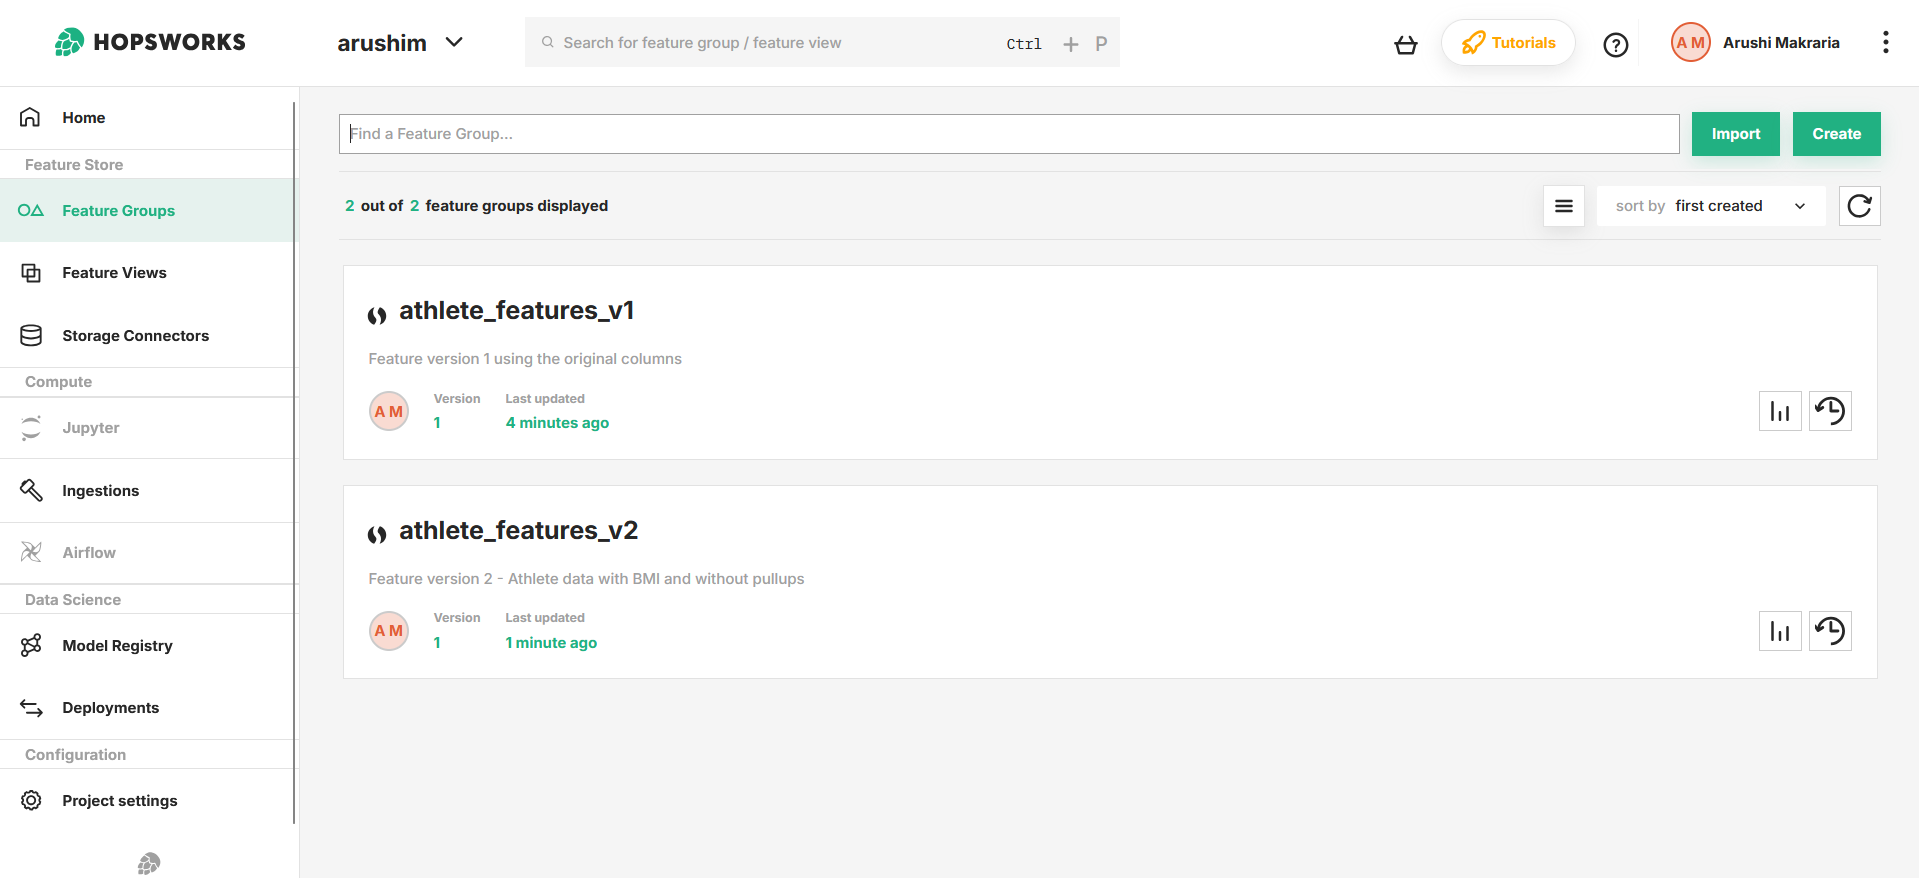

In [69]:
# Load feature version 1
feature_group_1 = fs.get_feature_group("athlete_features_v1", version=1)
feature_version_1 = feature_group_1.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 


In [70]:
# Load feature version 2
feature_group_2 = fs.get_feature_group("athlete_features_v2", version=1)
feature_version_2 = feature_group_2.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.89s) 


We will use MLFlow to track our work

In [71]:
mlflow.set_experiment("Athlete Data Experimentation")

<Experiment: artifact_location='file:///home/arushi/arushi/MLOPS/Assignment_2/mlruns/413342871679547533', creation_time=1730940299138, experiment_id='413342871679547533', last_update_time=1730940299138, lifecycle_stage='active', name='Athlete Data Experimentation', tags={}>

Defining functions for our Modelling

In [72]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
        
    def fit(self, X, y=None):
        for column in X.columns:
            le = LabelEncoder()
            le.fit(X[column])
            self.encoders[column] = le
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for column, le in self.encoders.items():
            X_transformed[column] = le.transform(X[column])
        return X_transformed
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [73]:
def run_model_pipeline(feature_data, params, feature_version):
    # Define features and target variable
    X = feature_data.drop(columns=['total_lift'])
    y = feature_data['total_lift']

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
    
    # Remove binary feature from categorical columns if needed
    if 'is_male' in categorical_cols:
        categorical_cols.remove('is_male')

    # Binary feature column for one-hot encoding
    binary_feature_col = ['is_male']

    # Define transformers for each type of feature
    numerical_transformer = StandardScaler()
    categorical_transformer = CustomLabelEncoder()
    binary_transformer = OneHotEncoder(drop='if_binary')

    # Combine all transformers in a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('binary', binary_transformer, binary_feature_col)
        ])

    # Create pipeline with preprocessor and XGBoost model
    xgb_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('xgboost', XGBRegressor(objective='reg:squarederror', **params))
    ])
    
    # Initialize emissions tracker with both GPU tracking disabled and process-only tracking mode
    emissions_tracker = EmissionsTracker(tracking_mode="process", gpu_ids=[])
    
    try:
        emissions_tracker.start()

        # Perform cross-validation
        cv_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='r2')

        # Split data and fit the model to training data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        xgb_pipeline.fit(X_train, y_train)

        # Make predictions on test data and calculate metrics
        y_pred = xgb_pipeline.predict(X_test)
        r2_test = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
    
        # Stop emissions tracker and capture carbon emissions
        carbon_emissions = emissions_tracker.stop()
        
    except Exception as e:
        print(f"An error occurred during pipeline execution: {e}")
        carbon_emissions = None
    
    finally:
        # Ensure emissions tracker is stopped if it was not already stopped
        try:
            emissions_tracker.stop()
        except Exception:
            print("Emissions tracker was not running or already stopped.")

    # Log parameters and results with MLflow
    with mlflow.start_run():
        mlflow.log_param('model_type', 'XGBoost')
        mlflow.log_param('feature_version', feature_version)
        mlflow.log_params(params)
        mlflow.log_metric('CV_Avg_R2', cv_scores.mean())
        mlflow.log_metric('Test_R2', r2_test)
        mlflow.log_metric('Test_RMSE', rmse)
        mlflow.log_metric('Test_MAE', mae)
        
        # Log carbon emissions if available
        if carbon_emissions is not None:
            mlflow.log_metric('Carbon_Emissions_kg', carbon_emissions)

    print("Pipeline run completed, and results have been logged in MLflow.")


In [74]:
def get_user_inputs():
    # Prompt for feature version
    feature_version = input("Choose feature version (1 or 2): ").strip()
    if feature_version == '1':
        selected_data = feature_version_1
    elif feature_version == '2':
        selected_data = feature_version_2
    else:
        print("Invalid input. Defaulting to version 1.")
        selected_data = feature_version_1
    
    # Define model as XGBoost with parameter prompts
    hyperparameters = {
        'n_estimators': int(input("Enter number of estimators (100, 150): ")),
        'max_depth': int(input("Enter max depth (5,6): ")),
        'learning_rate': float(input("Enter learning rate to control model updates (0.01,0.2): ")),
        'lambda': float(input("Set L2 regularization Strength (1.0, 3.0): "))
    }
    
    return selected_data, hyperparameters, feature_version

In [76]:
def main():
    # Unpack the values returned from get_user_inputs
    feature_data, params, feature_version = get_user_inputs()
    
    # Run the model pipeline with the specified inputs
    run_model_pipeline(feature_data, params, feature_version)

if __name__ == "__main__":
    main()

[codecarbon INFO @ 23:48:56] [setup] RAM Tracking...
[codecarbon INFO @ 23:48:56] [setup] GPU Tracking...
[codecarbon INFO @ 23:48:56] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:48:57] [setup] CPU Tracking...
[codecarbon WARNING @ 23:48:57] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 23:48:59] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13620H but we don't know it. Please contact us.
[codecarbon INFO @ 23:48:59] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13620H
[codecarbon INFO @ 23:48:59] >>> Tracker's metadata:
[codecarbon INFO @ 23:48:59]   Platform system: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
[codecarbon INFO @ 23:48:59]   Python version: 3.11.10
[codecarbon INFO @ 23:48:59]   CodeCarbon version: 2.7.2
[codecarbon INFO @ 23:48:59]   Available RAM : 7.610 GB
[codecarbon I

Pipeline run completed, and results have been logged in MLflow.


There is some bug in the latest version of code carbon so I have used version 2.5.0 to calculate the results.But with the older version there's some compatibility issue with the updated Nvidia drivers and it doesn't support them so there are some errors in the output but the results are being calculated. 


Attached is the link for the issue - https://github.com/mlco2/codecarbon/issues/702

In [ ]:
#Code carbon functional version - 2.5.0

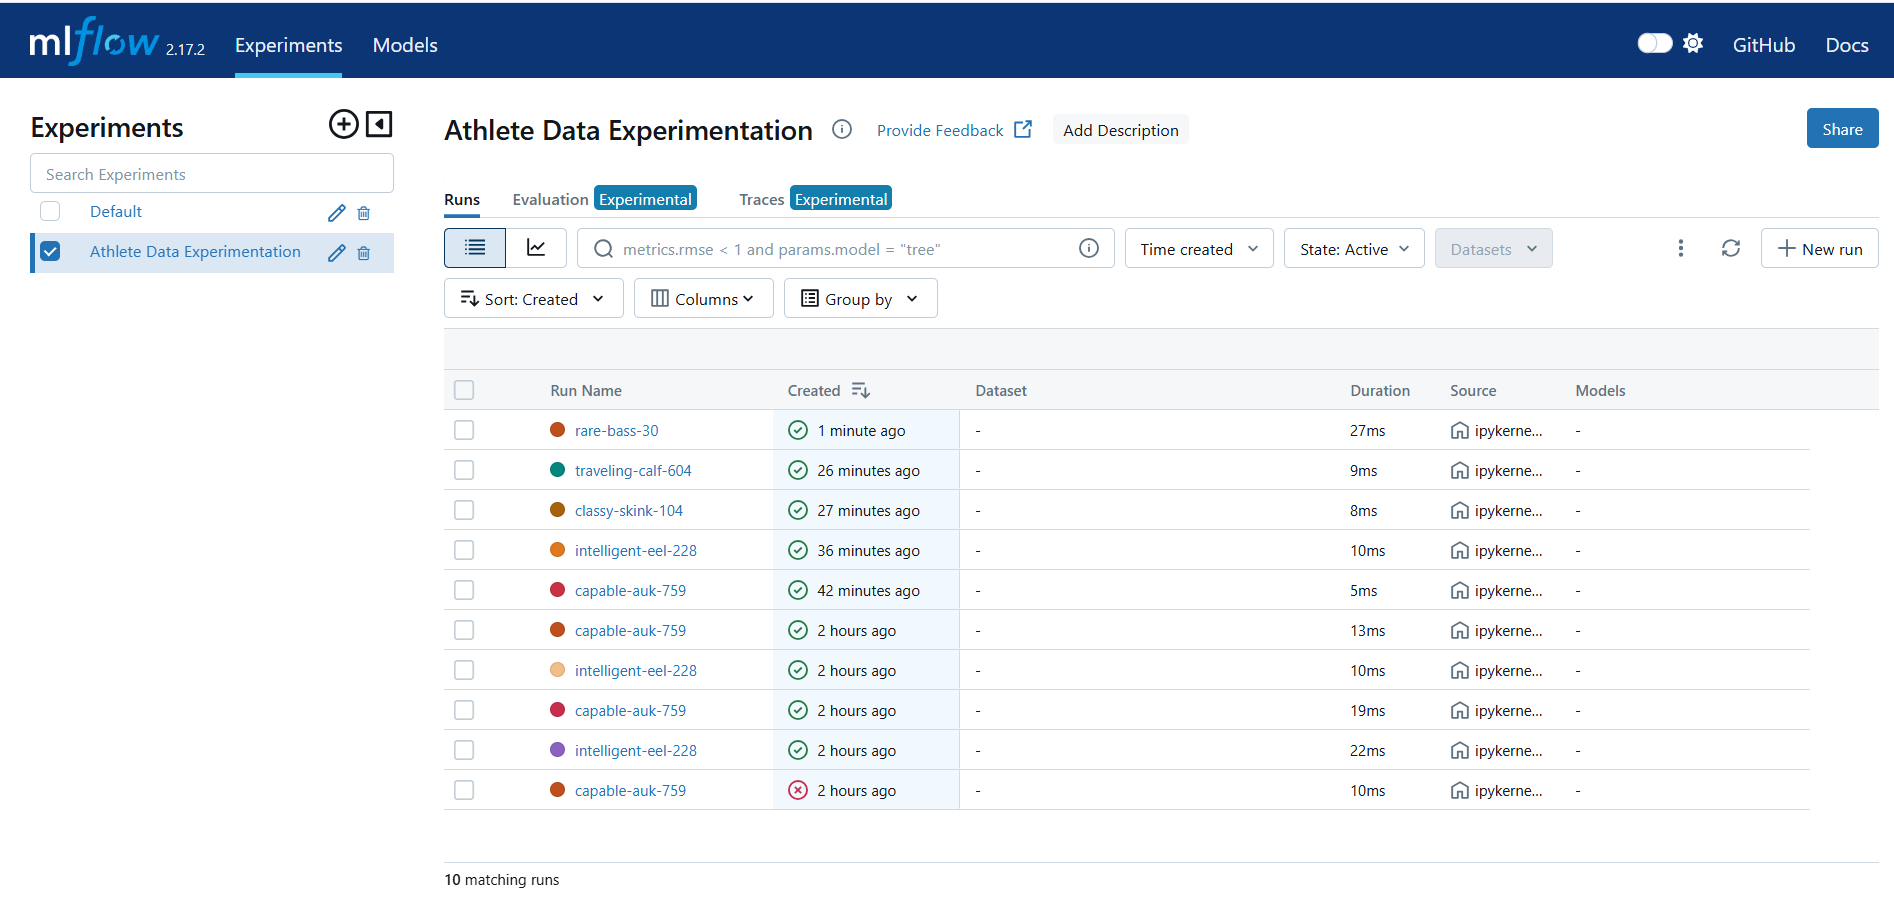

Feature 1 with hyper parameters - 
max_depth
6
learning_rate
1.0
n_estimators
500
lambda
4.0

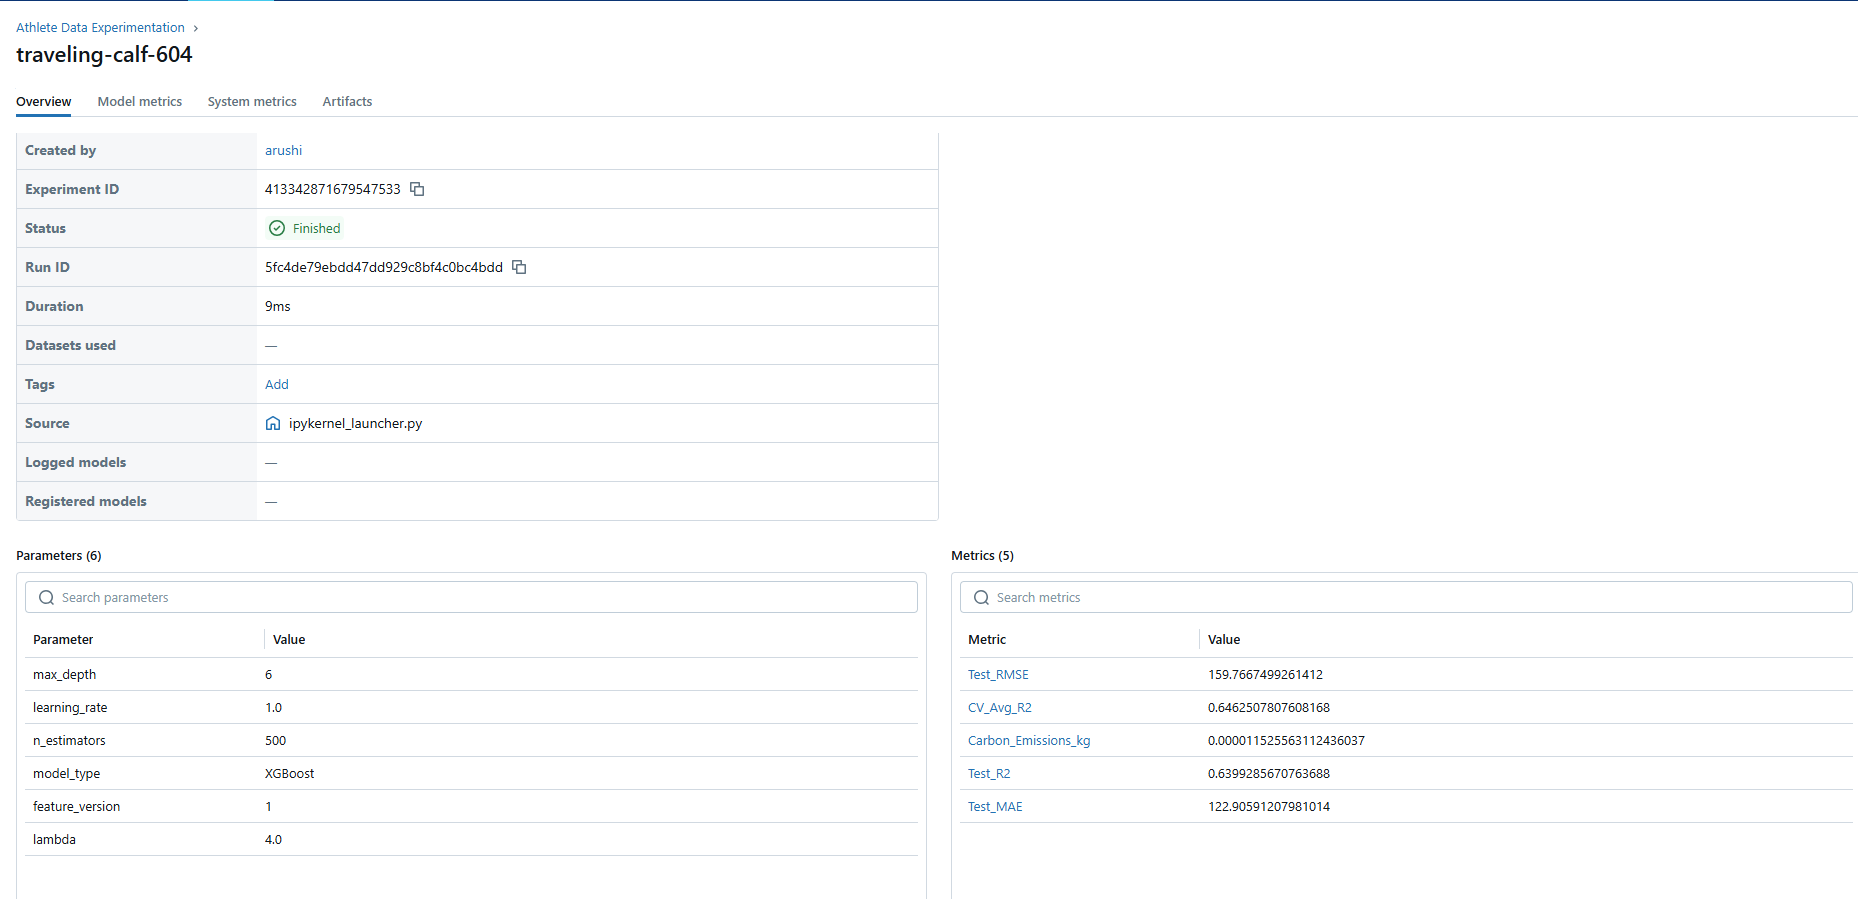

Feature 1 with hyperparameters - 
max_depth
5
learning_rate
0.01
n_estimators
100
lambda
2.0

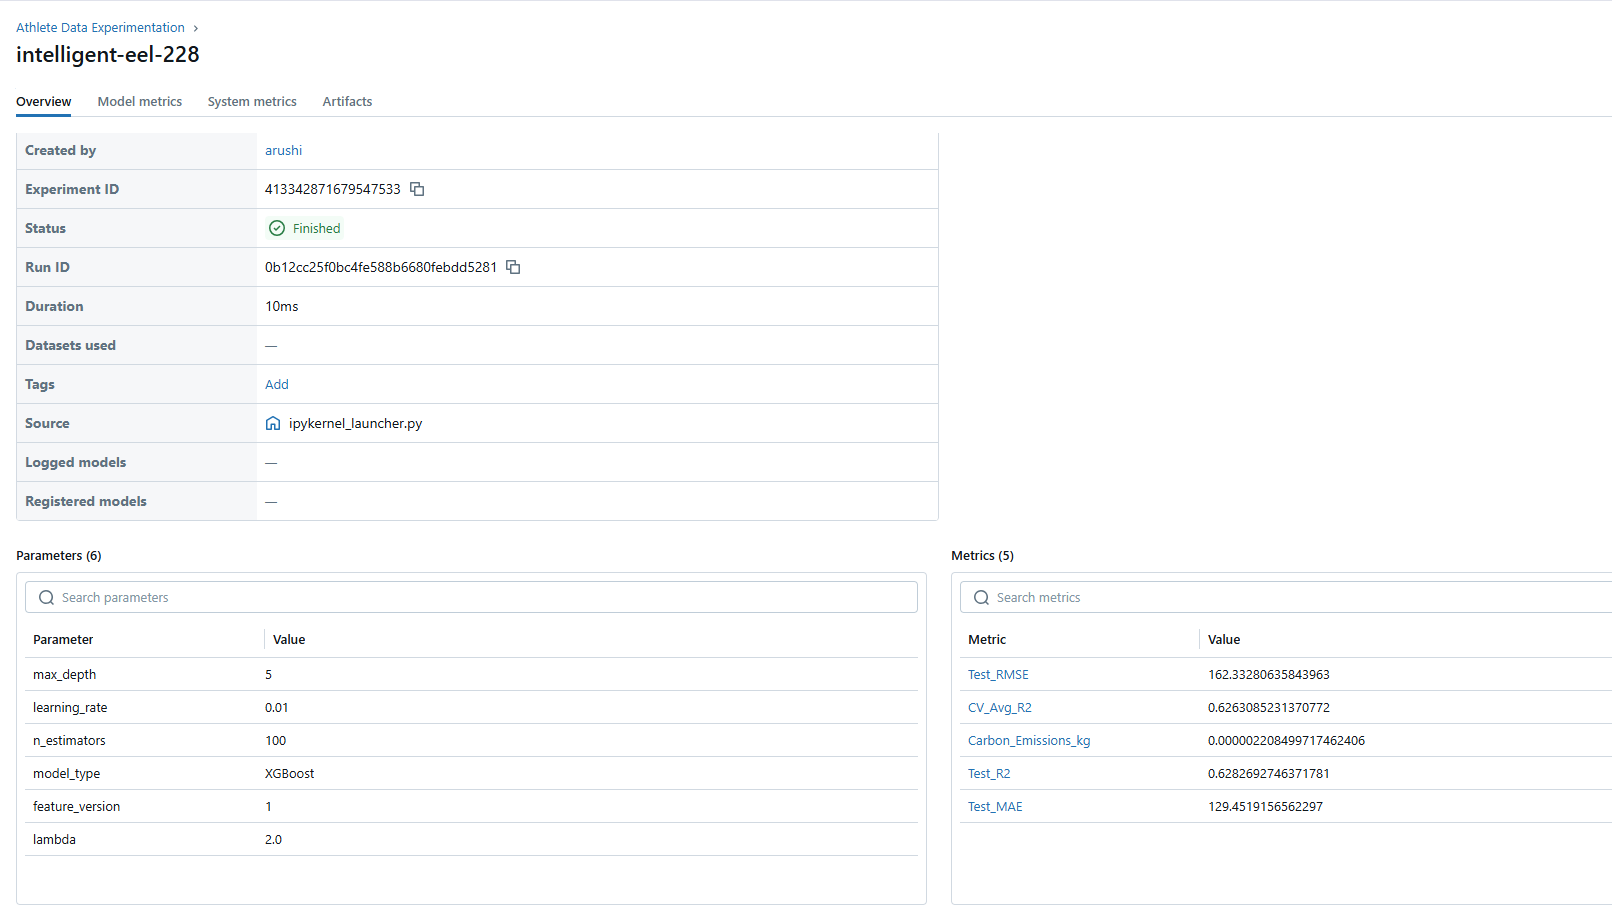

Feature 2 with hyperparameters -

max_depth
5
learning_rate
0.3
n_estimators
320
lambda
7.0

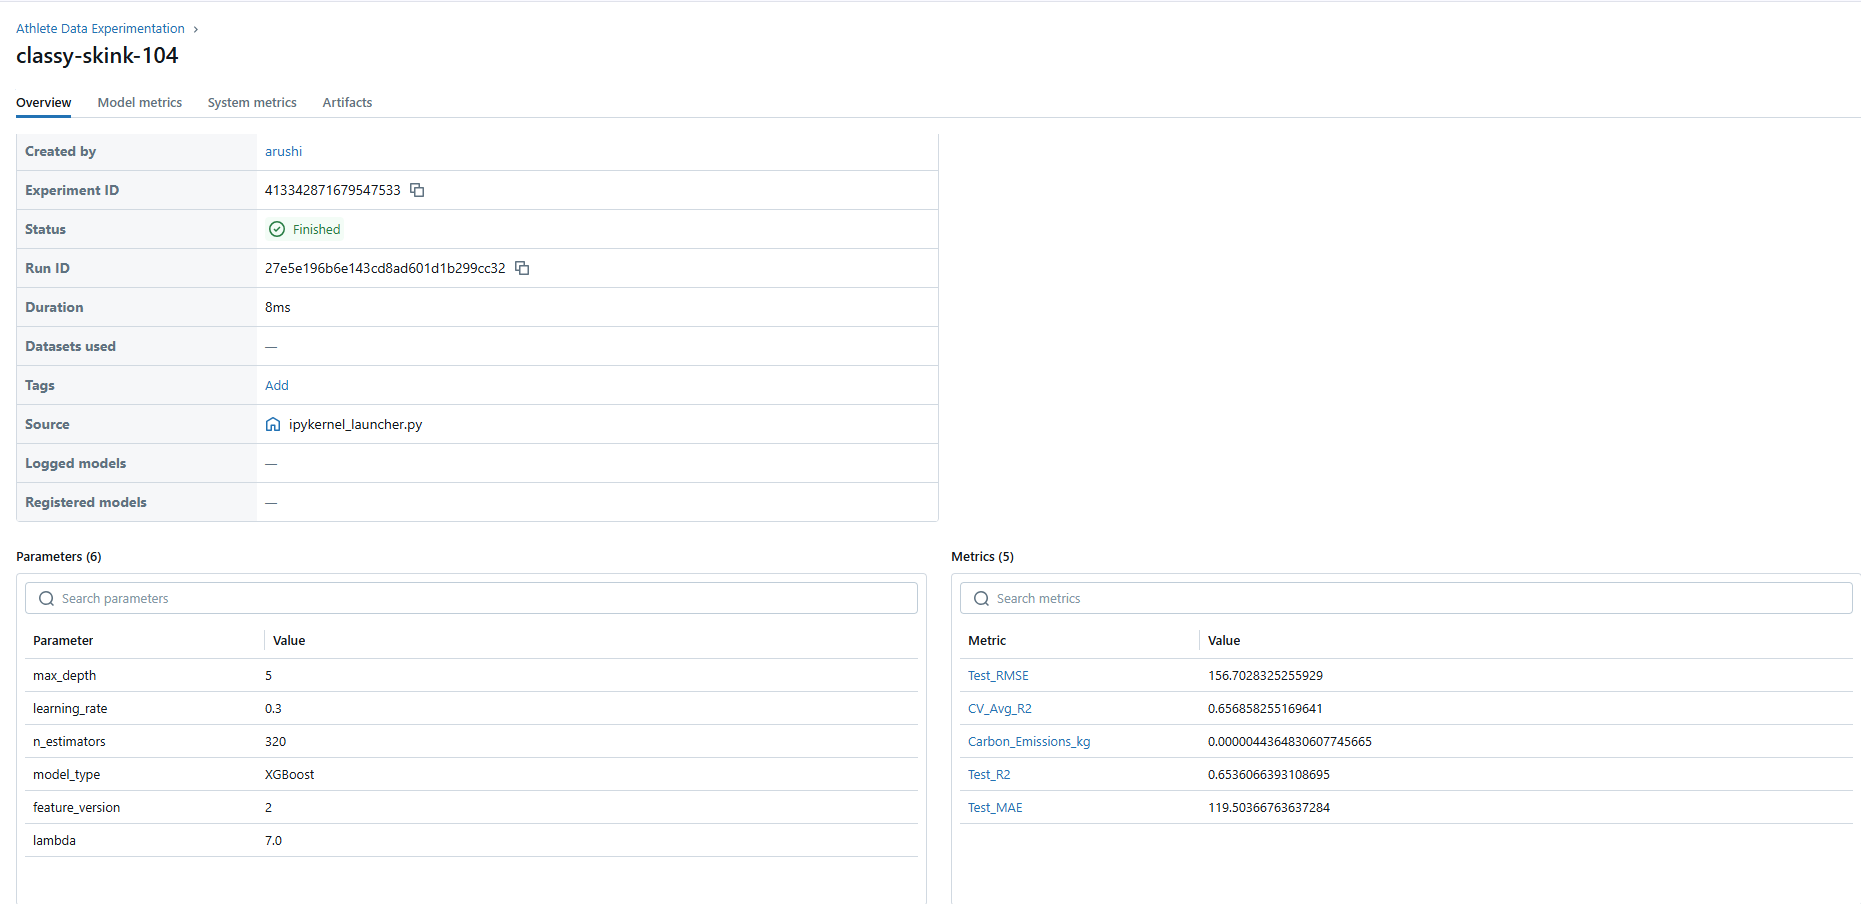

Feature 2 with hyperparameters - 
max_depth
6
learning_rate
0.5
n_estimators
210
lambda
4.0

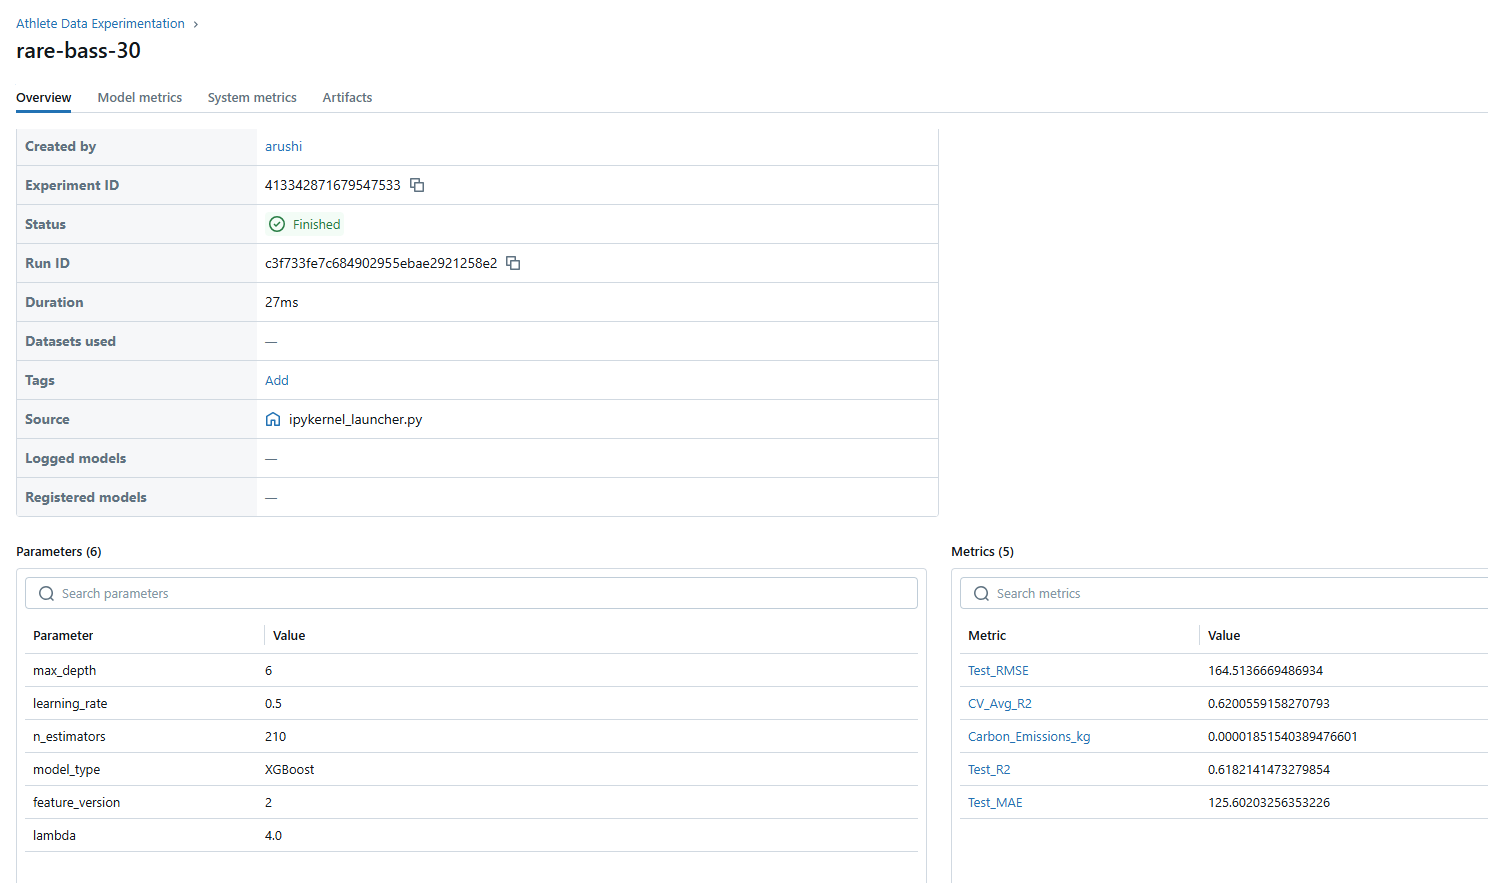

Fetching results in a DF

In [ ]:
# Initialize MLflow client
client = mlflow.tracking.MlflowClient()

# Experiment details
experiment_name = "Athlete Data Experimentation"
experiment = client.get_experiment_by_name(experiment_name)

# Check if experiment exists; if not, create it
if experiment is None:
    experiment_id = client.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

# Retrieve runs associated with the experiment
runs = client.search_runs(experiment_id)

# Initialize lists to store run details
feature_versions = []
model_types = []
parameters = []
test_r2_scores = []
carbon_emissions_kg = []

for run in runs:
    feature_version = run.data.params.get('feature_version')
    model_type = run.data.params.get('model_type')
    test_r2_score = run.data.metrics.get('Test_R2')
    emissions_kg = run.data.metrics.get('Carbon_Emissions_kg')
    
    # Append data to corresponding lists
    feature_versions.append(feature_version)
    model_types.append(model_type)
    parameters.append(run.data.params)
    test_r2_scores.append(test_r2_score)
    carbon_emissions_kg.append(emissions_kg)

# Create a DataFrame from the collected data
data = {
    'Feature Version': feature_versions,
    'Model Type': model_types,
    'Parameters': parameters,
    'Test R2 Score': test_r2_scores,
    'Carbon Emissions (kg CO2)': carbon_emissions_kg
}

# Convert to DataFrame
df = pd.DataFrame(data)
df.head(4)

,Feature Version,Model Type,Parameters,Test R2 Score,Carbon Emissions (kg CO2)
0,2,XGBoost,"{'max_depth': '6', 'learning_rate': '0.5', 'n_...",0.618214,0.000019
1,1,XGBoost,"{'max_depth': '6', 'learning_rate': '1.0', 'n_...",0.639929,0.000012
2,2,XGBoost,"{'max_depth': '5', 'learning_rate': '0.3', 'n_...",0.653607,0.000004
3,1,XGBoost,"{'max_depth': '5', 'learning_rate': '0.01', 'n...",0.628269,0.000002


In [ ]:
def create_experiment_label(row):
    feature_version = row['Feature Version']
    model_type = row['Model Type']
    
    # Model abbreviation (only XGBoost now)
    model_abbr = 'xgb' if model_type == 'xgboost' else model_type[:3]
    
    # Parameter set identifier
    params = row['Parameters']
    param_set = f"p{list(df['Parameters']).index(params) + 1}"  # Using df to index parameters
    
    # Combine components into the experiment label
    return f"f{feature_version}_{model_abbr}_{param_set}"

# Apply function to create 'Experiments' column
df['Experiments'] = df.apply(create_experiment_label, axis=1)


Observations and Evaluation

In [77]:
summary_stats = df.groupby("Feature Version").agg({
    'Test R2 Score': ['mean', 'std'],
    'Carbon Emissions (kg CO2)': ['mean', 'std']
}).reset_index()
print("Summary Statistics by Feature Version:\n", summary_stats)

Summary Statistics by Feature Version:
   Feature Version Test R2 Score           Carbon Emissions (kg CO2)          
                           mean       std                      mean       std
0               1      0.632335  0.006582                  0.000007  0.000007
1               2      0.627586  0.024926                  0.000011  0.000010


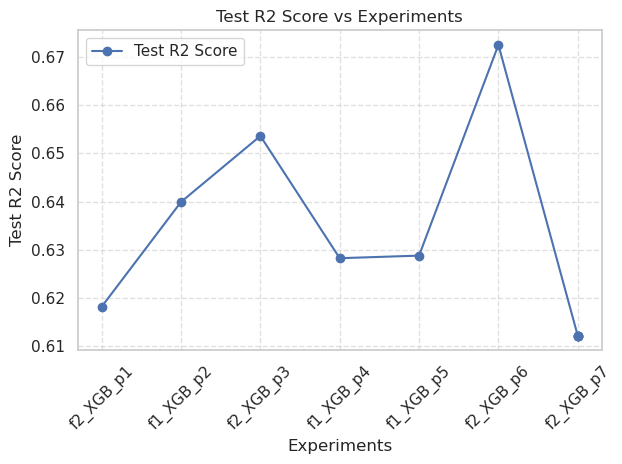

In [81]:
plt.plot(df['Experiments'], df['Test R2 Score'], marker='o', linestyle='-', color='b', label="Test R2 Score")
plt.xlabel('Experiments')
plt.ylabel('Test R2 Score')
plt.title('Test R2 Score vs Experiments')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()

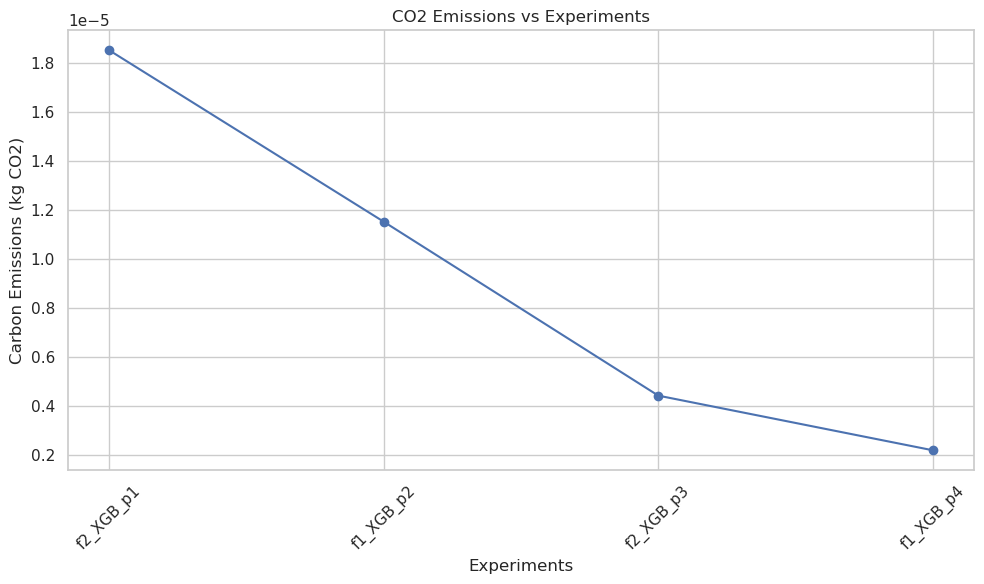

In [82]:
# Plotting CO2 Emissions vs Experiments
plt.figure(figsize=(10, 6))
plt.plot(df['Experiments'], df['Carbon Emissions (kg CO2)'], marker='o', linestyle='-', color='b')
plt.xlabel('Experiments')
plt.ylabel('Carbon Emissions (kg CO2)')
plt.title('CO2 Emissions vs Experiments')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

2024-11-06 23:49:54,926 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-06 23:49:54,964 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


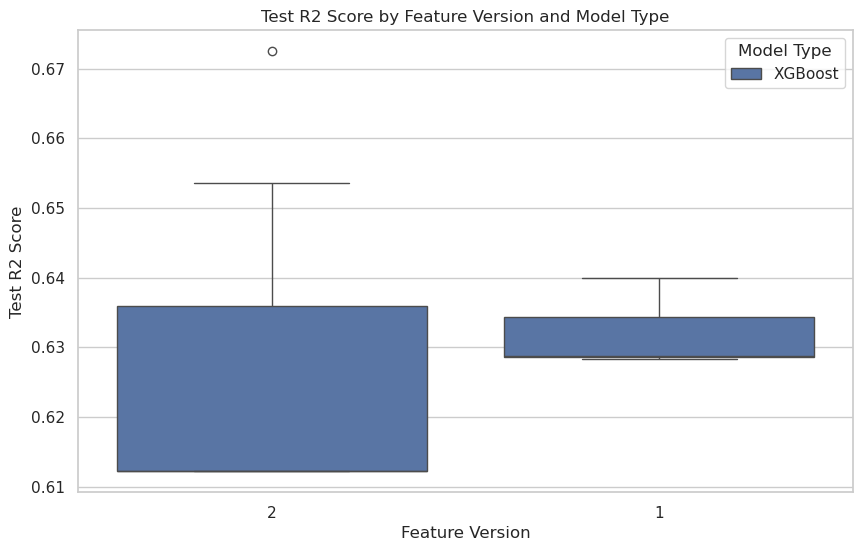

In [78]:
sns.set(style="whitegrid")

# Plot 1: Test R2 Score by Feature Version and Model Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Feature Version", y="Test R2 Score", hue="Model Type")
plt.title("Test R2 Score by Feature Version and Model Type")
plt.xlabel("Feature Version")
plt.ylabel("Test R2 Score")
plt.legend(title="Model Type")
plt.show()

2024-11-06 23:50:09,294 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-06 23:50:09,303 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


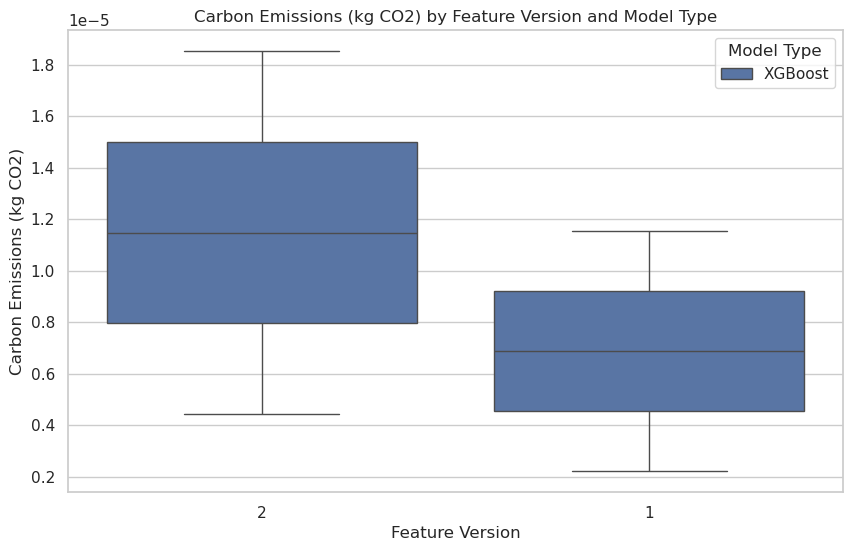

In [79]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Feature Version", y="Carbon Emissions (kg CO2)", hue="Model Type")
plt.title("Carbon Emissions (kg CO2) by Feature Version and Model Type")
plt.xlabel("Feature Version")
plt.ylabel("Carbon Emissions (kg CO2)")
plt.legend(title="Model Type")
plt.show()

2024-11-06 23:56:33,120 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-06 23:56:33,135 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


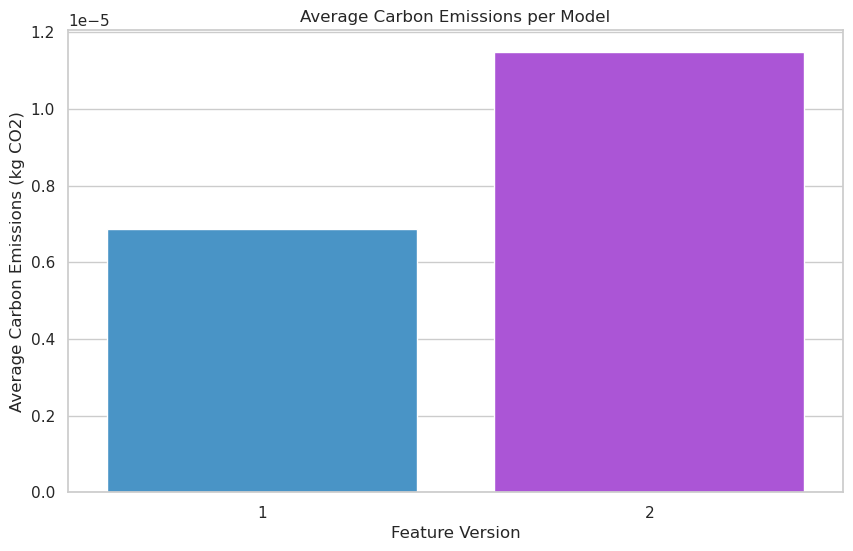

In [87]:
avg_emissions = df.groupby('Feature Version')['Carbon Emissions (kg CO2)'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
bar_colors = ['#3498db', '#b23fec']

sns.barplot(x='Feature Version', y='Carbon Emissions (kg CO2)', data=avg_emissions, palette=bar_colors)

plt.title('Average Carbon Emissions per Model')
plt.xlabel('Feature Version')
plt.ylabel('Average Carbon Emissions (kg CO2)')

plt.show()

In [89]:
df_with_emissions = df.dropna(subset=['Carbon Emissions (kg CO2)'])

best_model = df_with_emissions.loc[df_with_emissions['Test R2 Score'].idxmax()]

print("Best Model with Emissions Details:")
print(best_model)

Best Model with Emissions Details:
Feature Version                                                              2
Model Type                                                             XGBoost
Parameters                   {'max_depth': '5', 'learning_rate': '0.3', 'n_...
Test R2 Score                                                         0.653607
Carbon Emissions (kg CO2)                                             0.000004
Experiments                                                          f2_XGB_p3
Name: 2, dtype: object


### Observations

Experiment f2_XGB_p3 achieved the highest Test R2 Score of 0.6536, indicating it had the best predictive performance among the experiments. This suggests that the parameter combination and feature version used in this experiment contributed to better model accuracy.

The R2 score plot shows a variation across experiments, with some experiments achieving moderate performance while others significantly improved. The best-performing model stands out in terms of R2 score, showing a peak at f2_XGB_p3.

Feature version 2 generally shows higher average carbon emissions than feature version 1, as visualized in the box plot. However, the best-performing experiment (f2_XGB_p3) had relatively low emissions compared to other runs, indicating that it was both efficient and effective in terms of carbon footprint and model accuracy.

Feature version 2 tends to perform better in terms of R2 scores than feature version 1, as seen in the Test R2 Score plot. This suggests that the features included in version 2 might be more informative or better suited for the prediction task. However, this feature version also has a slightly higher carbon emission on average, indicating a trade-off between model accuracy and energy efficiency.

NameError: name 'feature_version_1' is not defined